# 简单 Encoder Transformer 架构实现

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

print(f"PyTorch版本: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

PyTorch版本: 2.8.0
使用设备: cpu


In [11]:
class MultiHeadAttention(nn.Module):
    """多头注意力机制实现"""
    
    def __init__(self, d_model, n_heads, dropout=0.1, debug=False):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.debug = debug
        
        # 线性变换层
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None  # 用于存储注意力权重
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        if self.debug:
            print(f"MultiHeadAttention 输入形状:")
            print(f"  Query: {query.shape}")
            print(f"  Key: {key.shape}")
            print(f"  Value: {value.shape}")
        
        # 1. 线性变换并分头
        # [batch_size, seq_len, d_model] -> [batch_size, n_heads, seq_len, d_k]
        Q = self.W_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        if self.debug:
            print(f"  分头后 Q: {Q.shape}")
            print(f"  分头后 K: {K.shape}")
            print(f"  分头后 V: {V.shape}")
        
        # 2. 计算缩放点积注意力
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        
        # 保存注意力权重用于可视化
        self.attention_weights = attention.detach().cpu()
        
        # 3. 应用注意力权重
        context = torch.matmul(attention, V)
        
        # 4. 拼接多头
        context = context.transpose(1, 2).contiguous().view(
            batch_size, seq_len, self.d_model
        )
        
        # 5. 最后的线性变换
        output = self.W_o(context)
        
        if self.debug:
            print(f"  输出形状: {output.shape}")
            print(f"  注意力权重形状: {attention.shape}")
        
        return output
    
    def get_attention_weights(self):
        """获取最后一次前向传播的注意力权重"""
        return self.attention_weights

# 测试 Multi-Head Attention
print("测试 Multi-Head Attention:")
print("-" * 50)
mha = MultiHeadAttention(d_model=512, n_heads=8, debug=True)
x = torch.randn(2, 10, 512)  # [batch_size, seq_len, d_model]
output = mha(x, x, x)
print(f"最终输出形状: {output.shape}")

测试 Multi-Head Attention:
--------------------------------------------------
MultiHeadAttention 输入形状:
  Query: torch.Size([2, 10, 512])
  Key: torch.Size([2, 10, 512])
  Value: torch.Size([2, 10, 512])
  分头后 Q: torch.Size([2, 8, 10, 64])
  分头后 K: torch.Size([2, 8, 10, 64])
  分头后 V: torch.Size([2, 8, 10, 64])
  输出形状: torch.Size([2, 10, 512])
  注意力权重形状: torch.Size([2, 8, 10, 10])
最终输出形状: torch.Size([2, 10, 512])



测试位置编码:
--------------------------------------------------
位置编码矩阵形状: torch.Size([5000, 1, 512])
PositionalEncoding 输入形状: torch.Size([10, 2, 512])
添加的位置编码形状: torch.Size([10, 1, 512])
输出形状: torch.Size([10, 2, 512])


/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/3613689907.py:84: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz

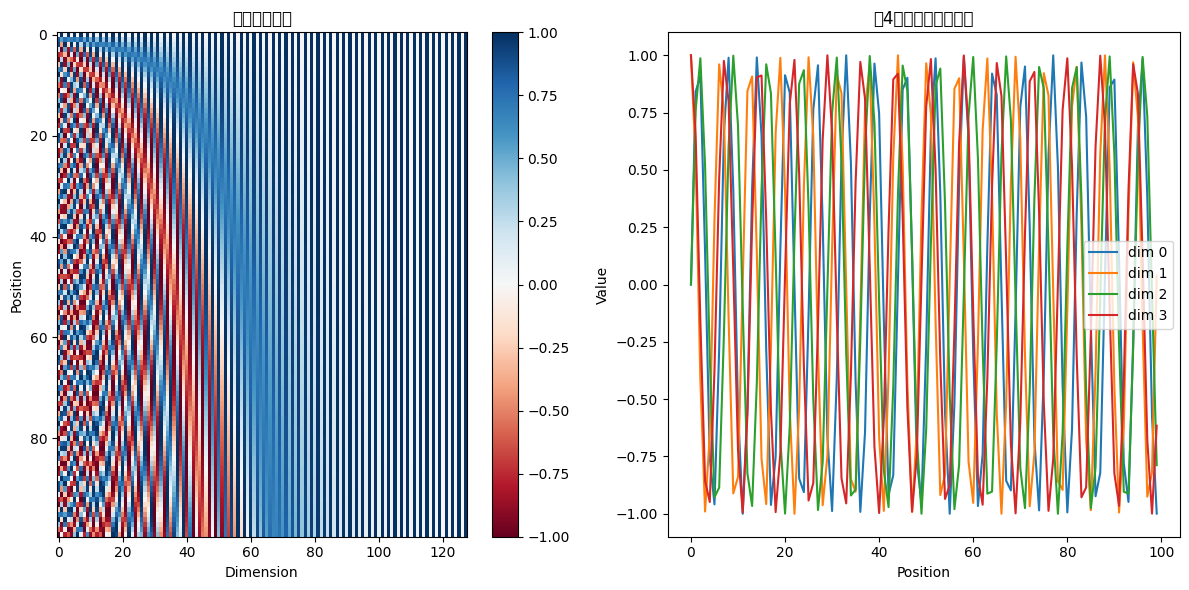

In [4]:
class PositionalEncoding(nn.Module):
    """位置编码实现 (使用正弦/余弦函数)"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1, debug=False):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.debug = debug
        
        # 创建位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # 创建频率分量
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        
        # 应用正弦和余弦函数
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数位置
        
        # 添加批次维度并注册为缓冲区
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        if self.debug:
            print(f"位置编码矩阵形状: {pe.shape}")
    
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, d_model]
        """
        if self.debug:
            print(f"PositionalEncoding 输入形状: {x.shape}")
            print(f"添加的位置编码形状: {self.pe[:x.size(0)].shape}")
        
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# 可选：可学习的位置嵌入
class LearnablePositionalEncoding(nn.Module):
    """可学习的位置编码"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        x = x + self.pos_embedding(positions)
        return self.dropout(x)

# 测试位置编码
print("\n测试位置编码:")
print("-" * 50)
pe = PositionalEncoding(d_model=512, debug=True)
x = torch.randn(10, 2, 512)  # [seq_len, batch_size, d_model]
output = pe(x)
print(f"输出形状: {output.shape}")

# 可视化位置编码
def visualize_positional_encoding(d_model=128, max_len=100):
    pe = PositionalEncoding(d_model, max_len)
    encoding = pe.pe[:max_len, 0, :].numpy()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(encoding, cmap='RdBu', aspect='auto')
    plt.colorbar()
    plt.xlabel('Dimension')
    plt.ylabel('Position')
    plt.title('位置编码热图')
    
    # 显示前几个维度的编码曲线
    plt.subplot(1, 2, 2)
    for i in range(4):
        plt.plot(encoding[:, i], label=f'dim {i}')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.title('前4个维度的位置编码')
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_positional_encoding()

In [5]:
class FeedForwardNetwork(nn.Module):
    """前馈网络 (Position-wise Feed-Forward Network)"""
    
    def __init__(self, d_model, d_ff, dropout=0.1, activation='relu', debug=False):
        super(FeedForwardNetwork, self).__init__()
        self.debug = debug
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # 选择激活函数
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")
    
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        if self.debug:
            print(f"FFN 输入形状: {x.shape}")
        
        # 第一层线性变换 + 激活
        hidden = self.linear1(x)
        hidden = self.activation(hidden)
        hidden = self.dropout(hidden)
        
        # 第二层线性变换
        output = self.linear2(hidden)
        output = self.dropout(output)
        
        if self.debug:
            print(f"FFN 中间层形状: {hidden.shape}")
            print(f"FFN 输出形状: {output.shape}")
        
        return output

# 测试前馈网络
print("\n测试前馈网络:")
print("-" * 50)
ffn = FeedForwardNetwork(d_model=512, d_ff=2048, activation='gelu', debug=True)
x = torch.randn(2, 10, 512)  # [batch_size, seq_len, d_model]
output = ffn(x)
print(f"最终输出形状: {output.shape}")


测试前馈网络:
--------------------------------------------------
FFN 输入形状: torch.Size([2, 10, 512])
FFN 中间层形状: torch.Size([2, 10, 2048])
FFN 输出形状: torch.Size([2, 10, 512])
最终输出形状: torch.Size([2, 10, 512])


In [6]:
class EncoderLayer(nn.Module):
    """Transformer Encoder 层"""
    
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, activation='gelu', debug=False):
        super(EncoderLayer, self).__init__()
        self.debug = debug
        
        # 子层
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout, debug=False)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff, dropout, activation, debug=False)
        
        # 层归一化
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
            mask: 可选的掩码张量
        """
        if self.debug:
            print(f"EncoderLayer 输入形状: {x.shape}")
        
        # 1. 多头自注意力 + 残差连接 + 层归一化
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        if self.debug:
            print(f"注意力后形状: {x.shape}")
        
        # 2. 前馈网络 + 残差连接 + 层归一化
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        if self.debug:
            print(f"EncoderLayer 输出形状: {x.shape}")
        
        return x
    
    def get_attention_weights(self):
        """获取注意力权重"""
        return self.self_attn.get_attention_weights()

# 测试 Encoder Layer
print("\n测试 Encoder Layer:")
print("-" * 50)
encoder_layer = EncoderLayer(
    d_model=512, 
    n_heads=8, 
    d_ff=2048, 
    dropout=0.1,
    activation='gelu',
    debug=True
)
x = torch.randn(2, 10, 512)  # [batch_size, seq_len, d_model]
output = encoder_layer(x)
print(f"最终输出形状: {output.shape}")

# 检查注意力权重
attn_weights = encoder_layer.get_attention_weights()
print(f"注意力权重形状: {attn_weights.shape}")  # [batch_size, n_heads, seq_len, seq_len]


测试 Encoder Layer:
--------------------------------------------------
EncoderLayer 输入形状: torch.Size([2, 10, 512])
注意力后形状: torch.Size([2, 10, 512])
EncoderLayer 输出形状: torch.Size([2, 10, 512])
最终输出形状: torch.Size([2, 10, 512])
注意力权重形状: torch.Size([2, 8, 10, 10])


In [7]:
class TransformerEncoder(nn.Module):
    """完整的 Transformer Encoder"""
    
    def __init__(self, 
                 vocab_size,
                 d_model=512,
                 n_heads=8,
                 n_layers=6,
                 d_ff=2048,
                 max_len=5000,
                 dropout=0.1,
                 activation='gelu',
                 use_learnable_pos_encoding=False,
                 debug=False):
        super(TransformerEncoder, self).__init__()
        self.debug = debug
        self.d_model = d_model
        
        # 输入嵌入层
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.scale = math.sqrt(d_model)  # 缩放因子
        
        # 位置编码
        if use_learnable_pos_encoding:
            self.pos_encoding = LearnablePositionalEncoding(d_model, max_len, dropout)
        else:
            self.pos_encoding = PositionalEncoding(d_model, max_len, dropout, debug=False)
        
        # Encoder 层堆叠
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout, activation, debug=False)
            for _ in range(n_layers)
        ])
        
        # 最后的层归一化
        self.norm = nn.LayerNorm(d_model)
        
        # 初始化参数
        self._init_parameters()
        
    def _init_parameters(self):
        """初始化模型参数"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, mask=None):
        """
        Args:
            src: 输入序列的索引 [batch_size, seq_len]
            mask: 可选的掩码张量
        Returns:
            output: [batch_size, seq_len, d_model]
        """
        if self.debug:
            print(f"TransformerEncoder 输入形状: {src.shape}")
        
        # 嵌入并缩放
        x = self.embedding(src) * self.scale
        
        if self.debug:
            print(f"嵌入后形状: {x.shape}")
        
        # 添加位置编码
        # 需要转换为 [seq_len, batch_size, d_model] 格式
        x = x.transpose(0, 1)
        x = self.pos_encoding(x)
        # 转换回 [batch_size, seq_len, d_model]
        x = x.transpose(0, 1)
        
        if self.debug:
            print(f"位置编码后形状: {x.shape}")
        
        # 通过所有 Encoder 层
        for i, layer in enumerate(self.layers):
            x = layer(x, mask)
            if self.debug and i == 0:
                print(f"第一层后形状: {x.shape}")
        
        # 最后的层归一化
        x = self.norm(x)
        
        if self.debug:
            print(f"最终输出形状: {x.shape}")
        
        return x
    
    def get_attention_weights_all_layers(self):
        """获取所有层的注意力权重"""
        weights = []
        for layer in self.layers:
            weights.append(layer.get_attention_weights())
        return weights

# 测试完整的 Encoder
print("\n测试完整的 Transformer Encoder:")
print("-" * 50)

# 创建模型
vocab_size = 10000
encoder = TransformerEncoder(
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    n_layers=6,
    d_ff=2048,
    max_len=1000,
    dropout=0.1,
    activation='gelu',
    debug=True
)

# 创建输入 (批次大小=2, 序列长度=20)
src = torch.randint(0, vocab_size, (2, 20))
print(f"输入 token IDs 形状: {src.shape}")

# 前向传播
output = encoder(src)
print(f"\n编码器输出形状: {output.shape}")

# 计算参数量
total_params = sum(p.numel() for p in encoder.parameters())
trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"\n模型参数量:")
print(f"  总参数: {total_params:,}")
print(f"  可训练参数: {trainable_params:,}")


测试完整的 Transformer Encoder:
--------------------------------------------------
输入 token IDs 形状: torch.Size([2, 20])
TransformerEncoder 输入形状: torch.Size([2, 20])
嵌入后形状: torch.Size([2, 20, 512])
位置编码后形状: torch.Size([2, 20, 512])
第一层后形状: torch.Size([2, 20, 512])
最终输出形状: torch.Size([2, 20, 512])

编码器输出形状: torch.Size([2, 20, 512])

模型参数量:
  总参数: 24,035,328
  可训练参数: 24,035,328



测试注意力权重可视化:
--------------------------------------------------
TransformerEncoder 输入形状: torch.Size([1, 15])
嵌入后形状: torch.Size([1, 15, 512])
位置编码后形状: torch.Size([1, 15, 512])
第一层后形状: torch.Size([1, 15, 512])
最终输出形状: torch.Size([1, 15, 512])


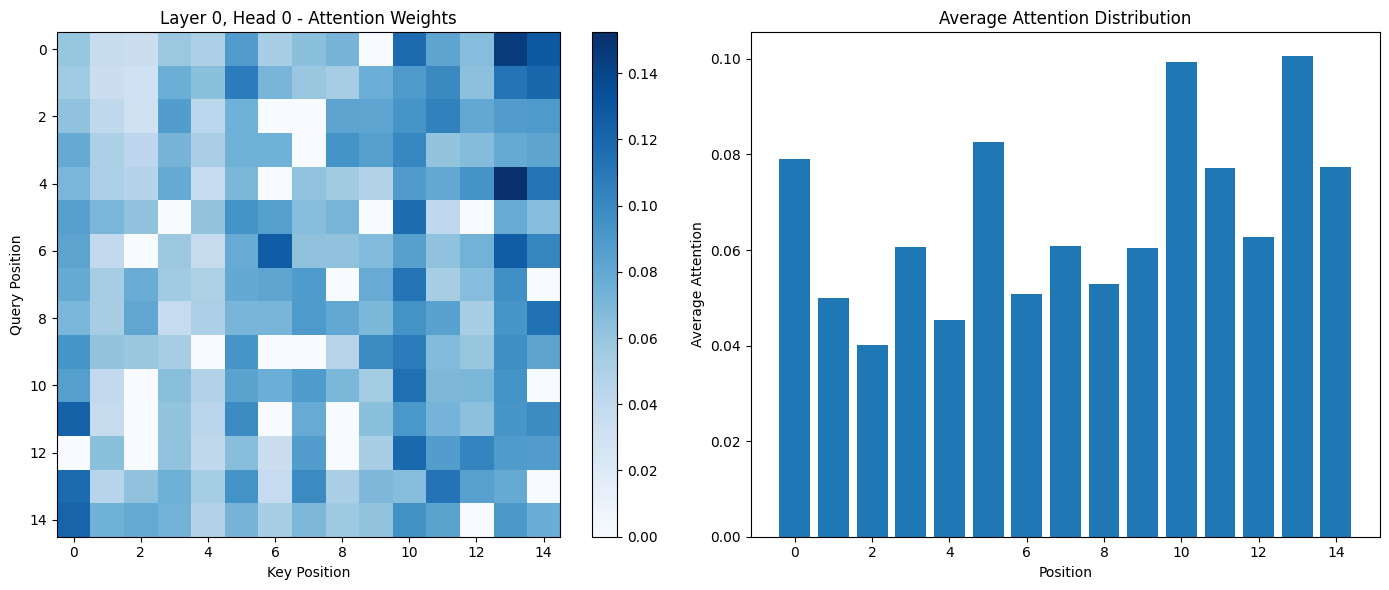


测试梯度流:

梯度流检查:
--------------------------------------------------------------------------------
Layer Name                                         Shape                Grad Norm       Status
--------------------------------------------------------------------------------
embedding.weight                                   [10000, 256]         0.000000        OK
layers.0.self_attn.W_q.weight                      [256, 256]           0.000000        OK
layers.0.self_attn.W_q.bias                        [256]                0.000000        OK
layers.0.self_attn.W_k.weight                      [256, 256]           0.000000        OK
layers.0.self_attn.W_k.bias                        [256]                0.000000        OK
layers.0.self_attn.W_v.weight                      [256, 256]           0.000000        OK
layers.0.self_attn.W_v.bias                        [256]                0.000000        OK
layers.0.self_attn.W_o.weight                      [256, 256]           0.000000        OK

In [8]:
# 调试和可视化功能

def visualize_attention_weights(encoder, src, layer_idx=0, head_idx=0):
    """可视化注意力权重"""
    # 前向传播
    with torch.no_grad():
        _ = encoder(src)
    
    # 获取所有层的注意力权重
    all_weights = encoder.get_attention_weights_all_layers()
    
    if layer_idx >= len(all_weights):
        print(f"Layer {layer_idx} 不存在，模型只有 {len(all_weights)} 层")
        return
    
    # 获取指定层的权重 [batch_size, n_heads, seq_len, seq_len]
    layer_weights = all_weights[layer_idx]
    
    # 选择第一个样本和指定的头
    attention = layer_weights[0, head_idx].numpy()
    
    # 创建可视化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 热图
    im1 = ax1.imshow(attention, cmap='Blues', aspect='auto')
    ax1.set_xlabel('Key Position')
    ax1.set_ylabel('Query Position')
    ax1.set_title(f'Layer {layer_idx}, Head {head_idx} - Attention Weights')
    plt.colorbar(im1, ax=ax1)
    
    # 平均注意力分布
    avg_attention = attention.mean(axis=0)
    ax2.bar(range(len(avg_attention)), avg_attention)
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Average Attention')
    ax2.set_title('Average Attention Distribution')
    
    plt.tight_layout()
    plt.show()

def check_gradient_flow(model):
    """检查梯度流"""
    # 创建虚拟输入和目标
    batch_size, seq_len = 2, 10
    vocab_size = 10000
    src = torch.randint(0, vocab_size, (batch_size, seq_len))
    
    # 前向传播
    output = model(src)
    
    # 创建虚拟损失
    loss = output.mean()
    
    # 反向传播
    loss.backward()
    
    # 检查梯度
    gradient_info = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            gradient_info.append({
                'name': name,
                'shape': list(param.shape),
                'grad_norm': grad_norm,
                'has_nan': torch.isnan(param.grad).any().item(),
                'has_inf': torch.isinf(param.grad).any().item()
            })
    
    # 打印梯度信息
    print("\n梯度流检查:")
    print("-" * 80)
    print(f"{'Layer Name':<50} {'Shape':<20} {'Grad Norm':<15} {'Status'}")
    print("-" * 80)
    
    for info in gradient_info[:10]:  # 只显示前10个
        status = "OK"
        if info['has_nan']:
            status = "NaN!"
        elif info['has_inf']:
            status = "Inf!"
        elif info['grad_norm'] == 0:
            status = "Zero!"
        elif info['grad_norm'] > 100:
            status = "Large!"
        
        print(f"{info['name']:<50} {str(info['shape']):<20} {info['grad_norm']:<15.6f} {status}")
    
    return gradient_info

def profile_model(model, input_shape=(2, 20)):
    """分析模型性能"""
    import time
    
    vocab_size = 10000
    src = torch.randint(0, vocab_size, input_shape).to(device)
    model = model.to(device)
    model.eval()
    
    # 预热
    with torch.no_grad():
        for _ in range(10):
            _ = model(src)
    
    # 计时
    times = []
    with torch.no_grad():
        for _ in range(100):
            start = time.time()
            _ = model(src)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            times.append(time.time() - start)
    
    times = np.array(times[10:])  # 去掉前10次
    
    print("\n性能分析:")
    print("-" * 50)
    print(f"设备: {device}")
    print(f"输入形状: {input_shape}")
    print(f"平均推理时间: {times.mean()*1000:.2f} ms")
    print(f"标准差: {times.std()*1000:.2f} ms")
    print(f"最小时间: {times.min()*1000:.2f} ms")
    print(f"最大时间: {times.max()*1000:.2f} ms")
    
    # 计算吞吐量
    batch_size, seq_len = input_shape
    throughput = batch_size * seq_len / times.mean()
    print(f"吞吐量: {throughput:.0f} tokens/秒")

# 测试可视化
print("\n测试注意力权重可视化:")
print("-" * 50)
src = torch.randint(0, vocab_size, (1, 15))
visualize_attention_weights(encoder, src, layer_idx=0, head_idx=0)

# 测试梯度流
print("\n测试梯度流:")
encoder_test = TransformerEncoder(
    vocab_size=10000,
    d_model=256,
    n_heads=4,
    n_layers=3,
    d_ff=1024
)
gradient_info = check_gradient_flow(encoder_test)

# 测试性能
print("\n测试性能:")
profile_model(encoder, input_shape=(4, 50))


测试文本分类任务:

生成合成数据集...
训练集大小: 500
序列长度: 15
类别数: 3

开始训练...
Epoch [2/10], Loss: 1.1096, Accuracy: 0.3540
Epoch [4/10], Loss: 0.4396, Accuracy: 0.8320
Epoch [6/10], Loss: 0.1533, Accuracy: 0.9340
Epoch [8/10], Loss: 0.0426, Accuracy: 0.9920
Epoch [10/10], Loss: 0.0098, Accuracy: 0.9980


/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm/b9nz80jj217df20r749_k4l80000gr/T/ipykernel_20502/2107737019.py:160: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nm

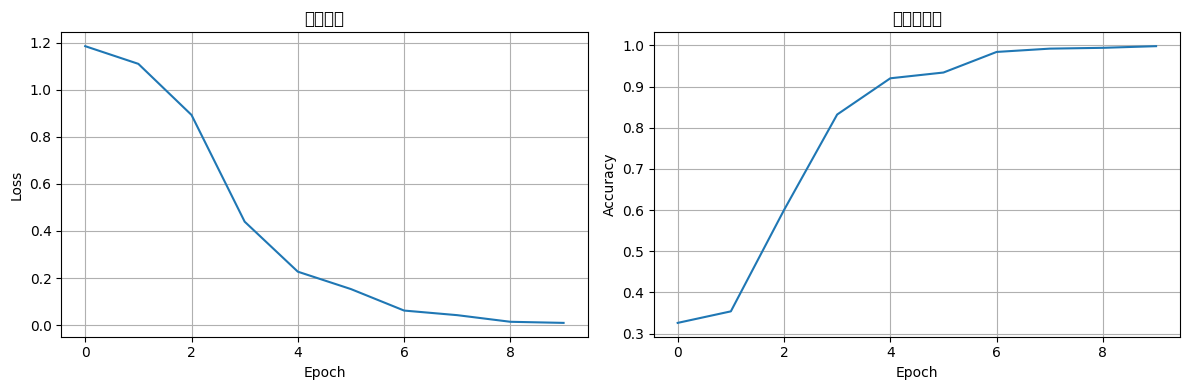


✅ 文本分类任务测试完成！


In [9]:
# 简单的文本分类任务示例

class TextClassifier(nn.Module):
    """基于 Transformer Encoder 的文本分类器"""
    
    def __init__(self, encoder, num_classes):
        super(TextClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.d_model, num_classes)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, mask=None):
        # 获取编码器输出
        encoder_output = self.encoder(x, mask)  # [batch_size, seq_len, d_model]
        
        # 使用平均池化获取句子表示
        sentence_repr = encoder_output.mean(dim=1)  # [batch_size, d_model]
        
        # 分类
        sentence_repr = self.dropout(sentence_repr)
        logits = self.classifier(sentence_repr)
        
        return logits

# 创建一个简单的合成数据集进行测试
def create_synthetic_dataset(num_samples=1000, seq_len=20, vocab_size=1000, num_classes=3):
    """创建合成数据集"""
    # 随机生成输入序列
    X = torch.randint(0, vocab_size, (num_samples, seq_len))
    
    # 简单规则：基于序列中某些特定 token 的出现来分类
    y = []
    for seq in X:
        # 规则：如果序列前3个token的和模3等于类别
        label = seq[:3].sum().item() % num_classes
        y.append(label)
    
    y = torch.tensor(y)
    
    return X, y

# 训练函数
def train_classifier(model, train_X, train_y, epochs=10, batch_size=32, lr=0.001):
    """训练分类器"""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    num_samples = len(train_X)
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        
        # 打乱数据
        indices = torch.randperm(num_samples)
        train_X = train_X[indices]
        train_y = train_y[indices]
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            
            batch_X = train_X[start_idx:end_idx].to(device)
            batch_y = train_y[start_idx:end_idx].to(device)
            
            # 前向传播
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # 统计
            epoch_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        
        avg_loss = epoch_loss / num_batches
        accuracy = correct / total
        losses.append(avg_loss)
        accuracies.append(accuracy)
        
        if (epoch + 1) % 2 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return losses, accuracies

# 测试完整的文本分类流程
print("\n测试文本分类任务:")
print("=" * 60)

# 创建小型编码器用于测试
small_encoder = TransformerEncoder(
    vocab_size=1000,
    d_model=128,
    n_heads=4,
    n_layers=2,
    d_ff=512,
    dropout=0.1
).to(device)

# 创建分类器
num_classes = 3
classifier = TextClassifier(small_encoder, num_classes).to(device)

# 创建数据集
print("\n生成合成数据集...")
train_X, train_y = create_synthetic_dataset(
    num_samples=500,
    seq_len=15,
    vocab_size=1000,
    num_classes=num_classes
)

print(f"训练集大小: {len(train_X)}")
print(f"序列长度: {train_X.shape[1]}")
print(f"类别数: {num_classes}")

# 训练模型
print("\n开始训练...")
losses, accuracies = train_classifier(
    classifier,
    train_X,
    train_y,
    epochs=10,
    batch_size=32,
    lr=0.001
)

# 可视化训练过程
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练损失')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('训练准确率')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n✅ 文本分类任务测试完成！")

In [10]:
# 调试工具总结

print("=" * 80)
print("🎯 Transformer Encoder 实现完成！")
print("=" * 80)

print("\n📚 已实现的组件：")
print("1. ✅ Multi-Head Attention - 多头注意力机制")
print("2. ✅ Positional Encoding - 位置编码（正弦/余弦 & 可学习）")
print("3. ✅ Feed-Forward Network - 前馈网络")
print("4. ✅ Encoder Layer - 编码器层（含残差连接和层归一化）")
print("5. ✅ Transformer Encoder - 完整编码器堆栈")
print("6. ✅ Text Classifier - 文本分类器示例")

print("\n🛠️ 调试功能：")
print("1. 📊 形状打印 - 每层输入输出形状")
print("2. 🎨 注意力可视化 - 热图和分布图")
print("3. 📈 梯度流检查 - 检测梯度消失/爆炸")
print("4. ⚡ 性能分析 - 推理时间和吞吐量")
print("5. 📉 训练监控 - 损失和准确率曲线")

print("\n💡 使用提示：")
print("• 设置 debug=True 来查看详细的中间输出")
print("• 使用 visualize_attention_weights() 可视化注意力模式")
print("• 使用 check_gradient_flow() 诊断训练问题")
print("• 使用 profile_model() 评估性能")

print("\n📝 下一步可以尝试：")
print("• 添加 Decoder 实现完整的 Transformer")
print("• 实现不同的注意力机制（如 Sparse Attention）")
print("• 添加更多的位置编码方式（如 RoPE）")
print("• 在真实数据集上训练和评估")
print("• 实现 beam search 等解码策略")

print("\n✨ Happy Debugging! ✨")

🎯 Transformer Encoder 实现完成！

📚 已实现的组件：
1. ✅ Multi-Head Attention - 多头注意力机制
2. ✅ Positional Encoding - 位置编码（正弦/余弦 & 可学习）
3. ✅ Feed-Forward Network - 前馈网络
4. ✅ Encoder Layer - 编码器层（含残差连接和层归一化）
5. ✅ Transformer Encoder - 完整编码器堆栈
6. ✅ Text Classifier - 文本分类器示例

🛠️ 调试功能：
1. 📊 形状打印 - 每层输入输出形状
2. 🎨 注意力可视化 - 热图和分布图
3. 📈 梯度流检查 - 检测梯度消失/爆炸
4. ⚡ 性能分析 - 推理时间和吞吐量
5. 📉 训练监控 - 损失和准确率曲线

💡 使用提示：
• 设置 debug=True 来查看详细的中间输出
• 使用 visualize_attention_weights() 可视化注意力模式
• 使用 check_gradient_flow() 诊断训练问题
• 使用 profile_model() 评估性能

📝 下一步可以尝试：
• 添加 Decoder 实现完整的 Transformer
• 实现不同的注意力机制（如 Sparse Attention）
• 添加更多的位置编码方式（如 RoPE）
• 在真实数据集上训练和评估
• 实现 beam search 等解码策略

✨ Happy Debugging! ✨
